In [1]:
%cd ..

/home/work/AnacondaProjects/combinators


In [2]:
from combinators import lens, sampler, tracing, utils
from combinators.lens import LensPRO

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
from torch.distributions.continuous_bernoulli import ContinuousBernoulli
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch

In [4]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 256
NUM_DIGITS = 10
NUM_LATENT = 10

# training parameters
NUM_SAMPLES = 2
NUM_BATCH = 128
NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9
CUDA = torch.cuda.is_available()

# path parameters
MODEL_NAME = 'mnist-%02ddim' % NUM_LATENT
DATA_PATH = 'data'
WEIGHTS_PATH = 'weights'
RESTORE = False

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, num_hidden=NUM_HIDDEN, num_latent=NUM_LATENT):
        super().__init__()
        
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_pixels, num_hidden),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
    
    def forward(self, q, images):
        hiddens = self.enc_hidden(images)
        q.normal(self.z_mean(hiddens),
                 self.z_log_std(hiddens).exp(),
                 name='z')
        return None, q

In [6]:
class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.register_buffer('z_mean', torch.zeros(num_latent))
        self.register_buffer('z_std', torch.ones(num_latent))
        self.dec_image = nn.Sequential(
                           nn.Linear(num_latent, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, p, images):
        z = p.normal(self.z_mean, 
                     self.z_std,
                     name='z')
        images_mean = self.dec_image(z)
        p.continuous_bernoulli(images_mean, name='x', value=images)
        return images_mean, p

In [7]:
enc = Encoder()
dec = Decoder()

In [8]:
mk_optimizer = lambda params: torch.optim.Adam(params,
                                               lr=LEARNING_RATE,
                                               betas=(BETA1, 0.999))

In [9]:
sampler = sampler.VariationalSampler(dec, enc, mk_optimizer, (NUM_SAMPLES,))

In [10]:
def dreg(log_weight, alpha=None):
    if alpha is None:
        alpha = torch.zeros_like(log_weight)
    probs = utils.normalize_weights(log_weight).detach().exp()
    particles = (alpha * probs + (1 - 2 * alpha) * probs**2) * log_weight
    return utils.batch_sum(particles)

def elbo(log_weight, iwae_objective=False, trace=None):
    if trace and all(trace[k].reparameterized for k in trace) and iwae_objective:
        return dreg(log_weight)
    elif iwae_objective:
        return utils.batch_marginalize(log_weight)
    return utils.batch_mean(log_weight)

In [11]:
vae = tracing.TracedLensBox('vae', LensPRO(1), LensPRO(1), sampler, sampler.update)

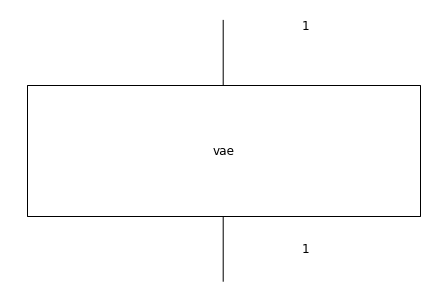

In [12]:
vae.draw()

In [13]:
vae.dom

LensPRO(1)

In [14]:
vae.cod

LensPRO(1)

In [15]:
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True)

In [16]:
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

if CUDA:
    vae.sample.cuda()
    cuda_tensors(vae.sample)

In [17]:
def train(data, vae):
    epoch_elbo = 0.0
    vae.sample.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            _, trace = vae(images)
            log_weight, trace = trace.fold()
            batch_elbo = elbo(log_weight, iwae_objective=True, trace=trace)
            loss = -batch_elbo
            loss.backward()
            vae.update(images, trace)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += float(batch_elbo.item())
    return epoch_elbo / N

def test(data, vae):
    vae.sample.eval()
    epoch_elbo = 0.0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            _, trace = vae(images)
            log_weight, trace = trace.fold()
            batch_elbo = elbo(log_weight, iwae_objective=True, trace=trace)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += float(batch_elbo.item())
    return epoch_elbo / N

In [18]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo = train(train_data, vae)
        train_end = time.time()
        test_start = time.time()
        test_elbo = test(test_data, vae)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e (%ds)' % (
                e+1, train_elbo, train_end - train_start, 
                test_elbo, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(vae.sample.state_dict(),
               '%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))

[Epoch 1] Train: ELBO 1.3669e+03 (8s) Test: ELBO 1.5820e+03 (1s)
[Epoch 2] Train: ELBO 1.6186e+03 (8s) Test: ELBO 1.6453e+03 (1s)
[Epoch 3] Train: ELBO 1.6691e+03 (8s) Test: ELBO 1.6940e+03 (1s)
[Epoch 4] Train: ELBO 1.6797e+03 (8s) Test: ELBO 1.6856e+03 (1s)
[Epoch 5] Train: ELBO 1.7072e+03 (8s) Test: ELBO 1.6698e+03 (1s)
[Epoch 6] Train: ELBO 1.7154e+03 (8s) Test: ELBO 1.7172e+03 (1s)
[Epoch 7] Train: ELBO 1.7133e+03 (7s) Test: ELBO 1.7267e+03 (1s)
[Epoch 8] Train: ELBO 1.7261e+03 (8s) Test: ELBO 1.7096e+03 (1s)
[Epoch 9] Train: ELBO 1.7321e+03 (8s) Test: ELBO 1.7195e+03 (1s)
[Epoch 10] Train: ELBO 1.7355e+03 (8s) Test: ELBO 1.7395e+03 (1s)
[Epoch 11] Train: ELBO 1.7258e+03 (8s) Test: ELBO 1.7542e+03 (1s)
[Epoch 12] Train: ELBO 1.7391e+03 (8s) Test: ELBO 1.7423e+03 (1s)
[Epoch 13] Train: ELBO 1.7414e+03 (8s) Test: ELBO 1.7570e+03 (1s)
[Epoch 14] Train: ELBO 1.7426e+03 (8s) Test: ELBO 1.7448e+03 (1s)
[Epoch 15] Train: ELBO 1.7574e+03 (7s) Test: ELBO 1.7568e+03 (1s)
[Epoch 16] Train: E

In [19]:
import numpy as np
ys = []
zs = []
for (x, y) in test_data:
    if len(x) == NUM_BATCH:
        images = x.view(-1, NUM_PIXELS)
        q = probtorch.Trace()
        if CUDA:
            _ , q = enc(q, images.cuda())
            z = q['z'].value.cpu().detach().numpy()
        else:
            _, q = enc(q, images)
            z = q['z'].value.data.detach().numpy()
        zs.append(z)
        ys.append(y.numpy())
ys = np.concatenate(ys,0)
zs = np.concatenate(zs,0)

In [20]:
# run TSNE when number of latent dims exceeds 2
if NUM_LATENT > 2:
    from sklearn.manifold import TSNE
    zs2 = TSNE().fit_transform(zs)
    zs2_mean = zs2.mean(0)
    zs2_std = zs2.std(0)
else:
    zs2 = zs

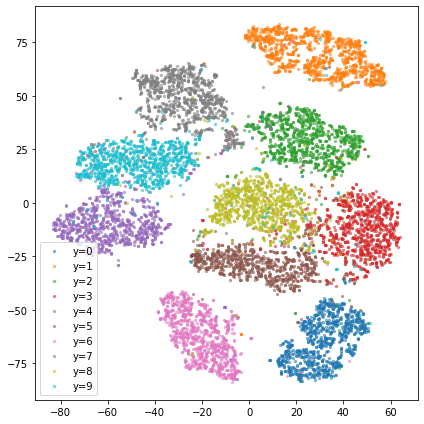

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

colors = []
for k in range(10):
    m = (ys == k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%d' % k, alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
#fig.savefig('images/%s-%02d-encodings.png' % (MODEL_NAME, NUM_STYLE), dpi=300)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

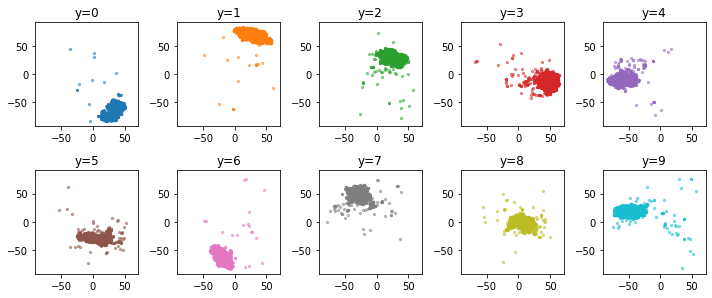

In [22]:
# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(10,4.25))

for k in range(10):
    ax = plt.subplot(2,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()

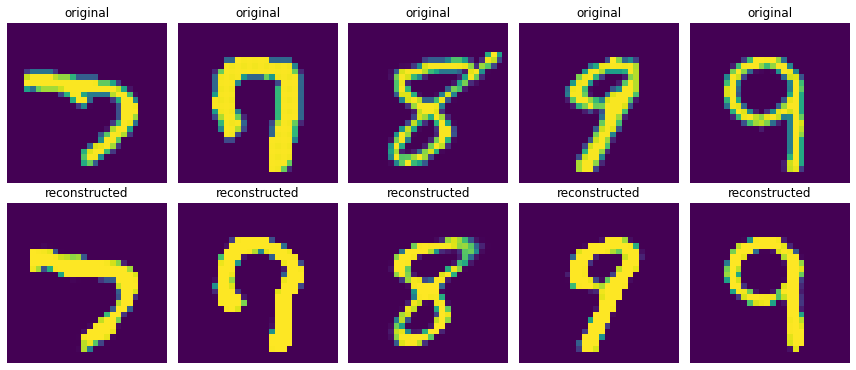

In [23]:
x,_ = next(iter(train_data))
x_var = x.view(-1, NUM_PIXELS)
q = probtorch.Trace()
if CUDA:
    _, q = enc(q, x_var.cuda())
    p = tracing.NestedTrace(q=q)
    x_mean, p = dec(p, x_var.cuda())
    x_mean = x_mean.view(NUM_BATCH, 28, 28).data.cpu().numpy()
else:
    _, q = enc(q, x_var)
    p = tracing.NestedTrace(q=q)
    x_mean, p = dec(p, x_var)
    x_mean = x_mean.view(NUM_BATCH, 28, 28).data.numpy().squeeze()
    
fig = plt.figure(figsize=(12,5.25))
for k in range(5):
    ax = plt.subplot(2, 5, k+1)
    ax.imshow(x[k].squeeze())
    ax.set_title("original")
    plt.axis("off")
    ax = plt.subplot(2, 5, k+6)
    ax.imshow(x_mean[k].squeeze())
    ax.set_title("reconstructed")
    plt.axis("off")
    
fig.tight_layout()
#fig.savefig('images/%s-%02d-reconstructions-separate.png' % (MODEL_NAME, NUM_STYLE), dpi=300, facecolor=[0,0,0,0])

In [24]:
from combinators.model import collections

In [25]:
iid_vae = vae >> collections.iid(vae.cod, 3)

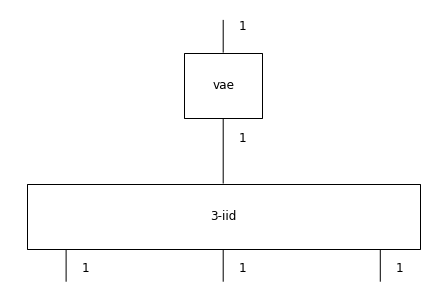

In [26]:
iid_vae.draw()

In [27]:
iid_vae(images.cuda())

((tensor([[[8.8548e-33, 1.6057e-31, 2.0315e-31,  ..., 6.6987e-33,
            3.2246e-31, 5.3739e-32],
           [8.2096e-37, 1.0150e-36, 2.9661e-35,  ..., 2.5206e-37,
            6.0825e-37, 1.0297e-35],
           [2.0495e-26, 4.0199e-27, 6.8467e-28,  ..., 1.5548e-26,
            1.0071e-26, 2.0715e-27],
           ...,
           [8.2757e-26, 2.3259e-26, 6.8145e-27,  ..., 7.6986e-27,
            1.2077e-27, 1.3597e-26],
           [1.0886e-29, 1.5464e-29, 1.2936e-29,  ..., 9.4874e-30,
            3.2253e-28, 6.3242e-30],
           [3.0303e-29, 4.6265e-28, 5.8491e-29,  ..., 1.0302e-27,
            1.8342e-27, 8.6893e-29]],
  
          [[2.2715e-32, 2.8952e-31, 3.7789e-31,  ..., 1.3844e-32,
            6.6959e-31, 1.2402e-31],
           [1.5307e-35, 1.5196e-35, 2.7692e-34,  ..., 4.2308e-36,
            6.7164e-36, 1.4211e-34],
           [8.1724e-27, 1.3027e-27, 2.7086e-28,  ..., 8.3516e-27,
            4.9725e-27, 8.1990e-28],
           ...,
           [1.2253e-25, 4.1946e-26, 9